In [1]:
!pip install transformers datasets torch

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import plot_model
from transformers import TFRobertaModel, RobertaTokenizerFast
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim import AdamW
from tqdm import tqdm

### Data

In [3]:
train_df = pd.read_csv('preprocessed_train.csv')
test_df = pd.read_csv('preprocessed_test.csv')
val_df = pd.read_csv('preprocessed_val.csv')

In [4]:
train_df = train_df[train_df['text'].apply(type) != float]
train_df.reset_index(drop=True, inplace=True)
print(train_df['text'].apply(type).value_counts())

text
<class 'str'>    22829
Name: count, dtype: int64


In [5]:
test_df = test_df[test_df['text'].apply(type) != float]
test_df.reset_index(drop=True, inplace=True)
print(test_df['text'].apply(type).value_counts())

text
<class 'str'>    2859
Name: count, dtype: int64


In [6]:
val_df = val_df[val_df['text'].apply(type) != float]
val_df.reset_index(drop=True, inplace=True)
print(val_df['text'].apply(type).value_counts())

text
<class 'str'>    2852
Name: count, dtype: int64


In [7]:
train_df.head()

,text,sentiment
0,fuck bayless isoing,anger
1,make feel threatened,fear
2,dirty southern wanker,anger
3,omg peyton good enough help u playoff dumbass ...,surprise
4,need board create bit space name we’ll good,joy


### Data Processing for model:

In [8]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained('cardiffnlp/twitter-roberta-base-emotion')

ros = RandomOverSampler()
x_train, y_train = ros.fit_resample(np.array(train_df['text']).reshape(-1, 1), np.array(train_df['sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in x_train], y_train)), columns = ['text', 'sentiment'])
train_os['sentiment'].value_counts()

sentiment
anger       7213
fear        7213
surprise    7213
joy         7213
sadness     7213
disgust     7213
Name: count, dtype: int64

In [9]:
X_train = train_os['text'].values
y_train = train_os['sentiment'].values

X_test = test_df['text'].values
y_test = test_df['sentiment'].values

X_valid = val_df['text'].values
y_valid = val_df['sentiment'].values

In [10]:
y_train = OneHotEncoder().fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = OneHotEncoder().fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = OneHotEncoder().fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [11]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

43

In [12]:
# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize the data
def tokenize_data(texts, labels, tokenizer, max_length=max_length):
    inputs = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    labels = torch.tensor(labels)  # Ensure labels are numeric
    return input_ids, attention_mask, labels

# Tokenize train and test data
train_input_ids, train_attention_mask, train_labels = tokenize_data(X_train, y_train, tokenizer)
test_input_ids, test_attention_mask, test_labels = tokenize_data(X_test, y_test, tokenizer)

# Ensure sizes match before creating datasets
min_length = min(train_input_ids.size(0), train_attention_mask.size(0), train_labels.size(0))

train_input_ids = train_input_ids[:min_length]
train_attention_mask = train_attention_mask[:min_length]
train_labels = train_labels[:min_length]

# Repeat for test data
min_length_test = min(test_input_ids.size(0), test_attention_mask.size(0), test_labels.size(0))

test_input_ids = test_input_ids[:min_length_test]
test_attention_mask = test_attention_mask[:min_length_test]
test_labels = test_labels[:min_length_test]

# Create PyTorch datasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [13]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode sentiments
train_df["sentiment_encoded"] = label_encoder.fit_transform(train_df["sentiment"])
test_df["sentiment_encoded"] = label_encoder.transform(test_df["sentiment"])

In [28]:
# Define a classifier using DistilBERT
class CustomDistilBertClassifier(nn.Module):
    """
    A custom classifier built on top of the DistilBERT model for text classification tasks.
    """
    def __init__(self, num_labels):
        """
        Initializes the CustomDistilBertClassifier with DistilBERT and additional layers.
        """
        super(CustomDistilBertClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        """
        Defines the forward pass for the model.
        """
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Use [CLS] token's output
        logits = self.classifier(cls_output)
        return logits

# Define the number of labels
num_labels = len(train_df["sentiment_encoded"].unique())

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomDistilBertClassifier(num_labels=num_labels).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [29]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=3):
    """
    Trains the given model using a specified optimizer, loss function, and data loader.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader providing batches of input_ids, attention_mask, and labels for training.
        optimizer (torch.optim.Optimizer): Optimizer used for gradient descent updates.
        loss_fn (callable): Loss function to calculate the difference between predictions and labels.
        epochs (int, optional): Number of training epochs. Defaults to 3.
        device (str, optional): Device to train on ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        None
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader)}")

In [30]:
def evaluate_model(model, test_loader, label_encoder):
    """
    Evaluates the performance of the given model on the test dataset.

    Args:
        model (nn.Module): The trained PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader providing batches of input_ids, attention_mask, and labels for testing.
        label_encoder (LabelEncoder): a fitted LabelEncoder for evaluation

    Returns:
        None: Prints evaluation metrics and displays a confusion matrix.
    """
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)  # Predicted class indices
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Ensure true_labels are converted to class indices if they are one-hot encoded
    true_labels = np.array(true_labels)
    if len(true_labels.shape) > 1:  # Check for one-hot encoded labels
        true_labels = np.argmax(true_labels, axis=1)
    
    # Compute accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy}")

    # Decode labels back to original string labels
    true_labels_decoded = label_encoder.inverse_transform(true_labels)
    predictions_decoded = label_encoder.inverse_transform(predictions)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_labels_decoded, predictions_decoded))

    # Confusion matrix
    cm = confusion_matrix(true_labels_decoded, predictions_decoded, labels=label_encoder.classes_)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
# Train the model
train_model(model, train_loader, optimizer, loss_fn, epochs=3)

Epoch 1/3: 100%|█████████████████████████████████████████████████████████████████| 1353/1353 [2:00:48<00:00,  5.36s/it]


Epoch 1 Loss: 0.8168357404088075


Epoch 2/3: 100%|█████████████████████████████████████████████████████████████████| 1353/1353 [2:13:02<00:00,  5.90s/it]


Epoch 2 Loss: 0.49673017466524944


Epoch 3/3: 100%|█████████████████████████████████████████████████████████████████| 1353/1353 [1:17:39<00:00,  3.44s/it]

Epoch 3 Loss: 0.34719593127629667


Test Accuracy: 0.658621895767751

Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.61      0.62       725
     disgust       0.57      0.48      0.52       123
        fear       0.64      0.74      0.69        98
         joy       0.78      0.75      0.76       857
     sadness       0.55      0.60      0.57       379
    surprise       0.62      0.65      0.63       677

    accuracy                           0.66      2859
   macro avg       0.63      0.64      0.63      2859
weighted avg       0.66      0.66      0.66      2859


Confusion Matrix:
[[443  21  11  60  79 111]
 [ 33  59   8   5   9   9]
 [  4   2  73  11   5   3]
 [ 67   2   6 641  41 100]
 [ 59   7   8  32 227  46]
 [ 88  13   8  75  53 440]]


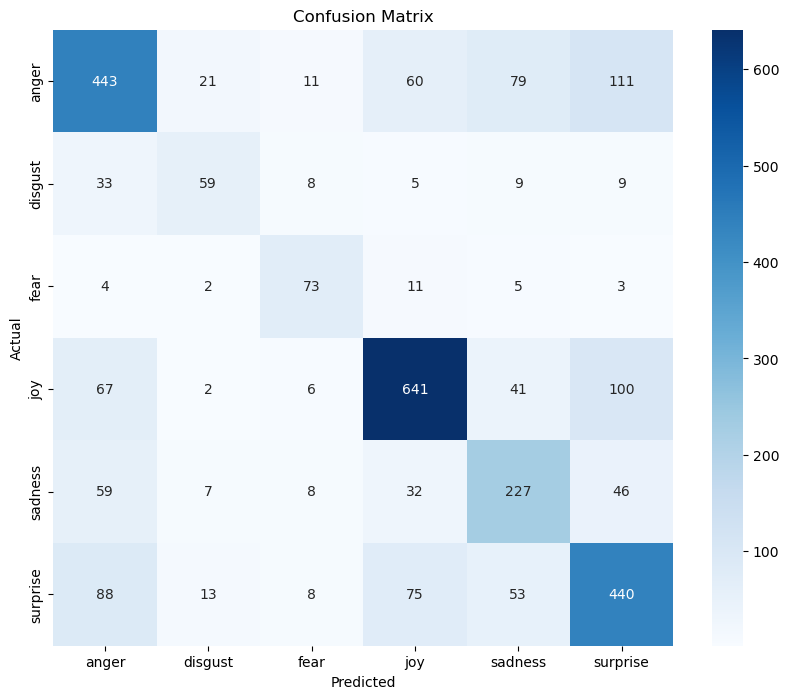

In [24]:
# Evaluate the model
evaluate_model(model, test_loader, label_encoder=label_encoder)